In [1]:
import pylab as plt
import numpy as np
import scipy
from tqdm import tqdm

In [38]:
def step_forward(u_last):
    NL = 1j*np.abs(u_last)**2*N**2  # Nonlinear operator
    ui = np.fft.ifft(np.exp(0.5 * dζ * DISP) * np.fft.fft(u_last))  # disp on half step
    ui = np.exp(dζ * NL) * ui  # full step NL
    ui = np.fft.ifft(np.exp(0.5 * dζ * DISP) * np.fft.fft(ui))  # disp on half step
    return ui

In [39]:
# scales

GHz =   1e9
ps  =   1e-12
ns  =   1e-9
km  =   1e3
nm  =   1e-9
mW  =   1e-3
W   =   1

# Constants

c = 3e8

# Simulation Parameters

Lmax = 5*km
Tmax = 200*ps

N_z = 5000
N_t = 800

# Physical Parameters

f0 = 10.00485 * GHz # envelope frequency
λ = 1550 * nm # source wavelength
γ = 1.1 /W/km # nonlinear factor
D = - 15.7 * ps/nm/km # dispersion factor # t0 have beta2 = 20 ps^2 / km
α =  0.046 / km # Fiber losses
β2 = - D*λ**2/(2*np.pi*c) # dispersion
T0 = 1/f0


P0 = 500 * mW # envelope power
#P0 = β2/(γ*T0**2) # ideal soliton power (N²=1)

# Vectors

t = Tmax*np.linspace(0,1, N_t) # time vector
z = Lmax*np.linspace(0,1, N_z) # distance vector

θ = np.pi
δ = 1.5

Vpi_rf = 4.2
Vpi_p = 4
Vpi_dc = 6.6

#V0 = Vpi_rf/2
#Vb = Vpi_dc/2
V0 = 2.1
Vb = 3.3

signal = np.cos(0.5*np.pi*V0/Vpi_rf*np.cos(2*np.pi*f0*t) + 0.5*np.pi*Vb/Vpi_dc) * np.exp(1j*np.pi*δ*V0/Vpi_p*np.cos(2*np.pi*f0*t+θ))
# Intermediate calculus

L_D = T0**2/np.abs(β2) # Dispersion length
L_N = 1/(P0*γ) # Nonlinear length
N = np.sqrt(L_D/L_N) # Soliton order

# Non-dimensionalization

ζ = z/L_D # adimension distance
τ = t/T0 # adimension local time

ζmax = Lmax/L_D
τmax = max(τ)

# steps
dτ = abs(τ[1]-τ[0])
dζ = abs(ζ[1]-ζ[0])

# adimension frequency
ν = (np.fft.fftfreq(N_t, d=dτ)) 

sgn = -1 # anomalous dispersion +1 if normal dispersion
DISP = sgn*0.5*(1j*(2*np.pi*ν)**2) - 0.5*α*L_D # dispersion operator (with losses)



u = np.zeros((N_z, N_t), dtype=complex) # time/frequency matrix
u[0,:] = signal # Chembo reproduced

# u[0, :] = 1/np.cosh(τ-0.5*τmax) # soliton initial pulse

In [40]:
for i in tqdm(range(1, len(ζ))):
    u[i] = step_forward(u[i - 1])
U = np.abs(u)**2*P0
Tz = []
for i in range(N_z):
    a = np.max(U[i,:])
    Tz = np.append(Tz, a)


100%|██████████| 4999/4999 [00:00<00:00, 6017.46it/s]


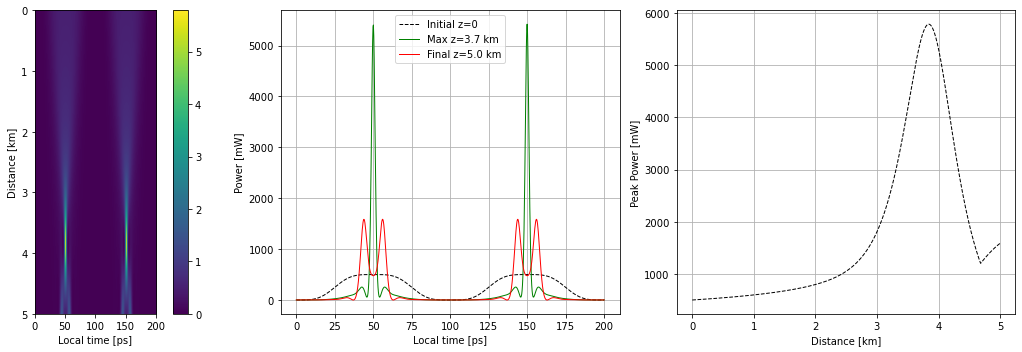

In [48]:
plt.figure(figsize=(16,5))
plt.subplot(1,3,1)
plt.imshow(U, extent=[0, Tmax/ps, Lmax/km, 0], aspect=100)
cm = plt.colorbar()
plt.ylabel(r"Distance [km]")
plt.xlabel(r"Local time [ps]")


plt.subplot(1,3,2)
plt.plot(t/ps,np.abs(U[0,:])/mW, lw=1, ls='--', color='black', label=r'Initial z=0')
l = 3.7e3
plt.plot(t/ps,np.abs(U[round(l*(N_z-1)/Lmax),:])/mW, lw=1, color='green', label=r'Max z={} km'.format(l/km))
plt.plot(t/ps,np.abs(U[-1,:])/mW, lw=1, color='red', label=r'Final z={} km'.format(Lmax/km))
plt.grid()
plt.legend()
plt.ylabel(r"Power [mW]")
plt.xlabel(r"Local time [ps]")

plt.subplot(1,3,3)
plt.plot(z/km,Tz/mW, lw=1, ls='--', color='black')
plt.grid()
plt.ylabel(r"Peak Power [mW]")
plt.xlabel(r"Distance [km]")

plt.tight_layout()
plt.show()


C:\Users\brian\AppData\Local\Temp/ipykernel_16944/2972581887.py:4: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


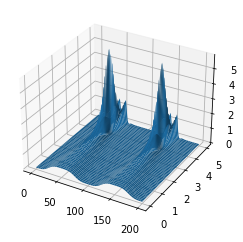

In [42]:



T, Z = np.meshgrid(t, z)

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(T/ps, Z/km, U)
plt.show()

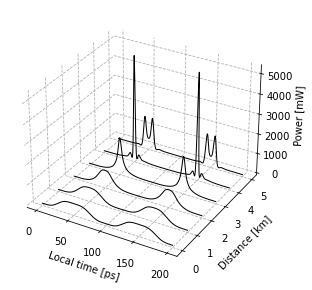

In [45]:

ax = plt.figure().add_subplot(projection='3d')
tt = t/ps

for i in range(0,6):
    ii = round((N_z-1)*i/5)
    ax.plot(tt, U[ii]/mW, zs=i, zdir='y', lw=1, color='black')
ax.set_xlabel('Local time [ps]')
ax.set_zlabel('Power [mW]')
ax.set_ylabel('Distance [km]')
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis._axinfo["grid"]['linestyle'] = "--"
ax.yaxis._axinfo["grid"]['linestyle'] = "--"
ax.xaxis._axinfo["grid"]['linestyle'] = "--"
plt.tight_layout()

In [37]:
β2 / ps **2 * km

20.010683624063255